# Problem wenn Steg verloren geht
Machmal geht beim Clustering der Steg verloren, das führt zu einer Fehlklassifikation ob Seite oder Befahren

In [134]:
import pdal 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.linalg import svd 
from osgeo import ogr
import pyvista as pv
import os
import json
import time 
import matplotlib.pyplot as plt

import open3d as o3d
from interessant import * # Bei Änderungen Kernel neu starten

ogr.UseExceptions()

In [135]:
tmpdir = "/media/riannek/minimax/gleis/temp_run24"

# Bahnsteig: 29; Gleis hohe Intensität: 11; Weiche B: 16; Unterirdischer Bhf: 20; Gleis weit abseits: 23; Betondeckel: 28; Zug run 14 A: 6; 
# Viele Gleise: 33; Anfang Weiche: 34; OLA gleiche H: 35; Y: 37; Auch viele Gleise: 43; Kreuzung: 44, 45;
# Nicht befahren: 50,51

key = list(interessant.keys())[50] 

filename = interessant[key]


# filename = "4474550_5332275.copc.laz"   ###############################


filename = filename.split(".")[0] + ".ply"
print(key, filename)


if not os.path.exists(os.path.join(tmpdir, "candidates",filename)):
    raise FileNotFoundError(filename)



Nicht befahren 1 4481400_5357025.ply


In [136]:
thresh_side_distance = 0.15   # 0.1 ist meist gut, aber in manchen Fällen zu wenig (z.B. Anfang Weiche)

intensity_threshold = 14500
downsample_radius = 0.45 # 0.4
neighborhood_radius = 0.5 # 0.5

min_points = 10
minimum_in_hood = 10
linearity_tresh = 0.98

gauge = 1.435
railhead_width = 0.067

In [137]:
runfolder = "/media/riannek/minimax/gleis/run24-2024-08-13"

import subprocess
# subprocess.Popen(["pyvistaviewer", os.path.join(runfolder, filename.split(".")[0] + ".copc.laz")])

## Datei incl. margin aus Nachbarkacheln

In [138]:
gpkg = ogr.Open(os.path.join(tmpdir, "temp.gpkg"))
layer = gpkg.GetLayerByName("tiles")

In [139]:
def extend_bbox(bbox, margin=2):
    # MinX, MaxX, MinY, MaxY
    return (bbox[0] - margin, bbox[1] + margin, bbox[2] - margin, bbox[3] + margin)

def get_bbox_polygon(bbox):  
    ring = ogr.Geometry(ogr.wkbLinearRing)      
    ring.AddPoint_2D(bbox[0], bbox[2])  # MinX, MinY
    ring.AddPoint_2D(bbox[1], bbox[2])  # MaxX, MinY
    ring.AddPoint_2D(bbox[1], bbox[3])  # MaxX, MaxY
    ring.AddPoint_2D(bbox[0], bbox[3])  # MinX, MaxY
    ring.AddPoint_2D(bbox[0], bbox[2])  # Close ring
    geom = ogr.Geometry(ogr.wkbPolygon)
    geom.AddGeometry(ring)
    return geom

In [140]:
filter = f"filename = '{filename}'"
layer.SetAttributeFilter(filter)
feature = layer.GetNextFeature()
layer.SetAttributeFilter(None)
bbox = feature.GetGeometryRef().GetEnvelope()
extended = extend_bbox(bbox, margin=2)
bbox_geom = get_bbox_polygon(extended)
layer.SetSpatialFilter(bbox_geom)
tiles = [f.GetField("filename") for f in layer]
layer.SetSpatialFilter(None) 

print(tiles) 

['4481375_5357050.ply', '4481375_5357025.ply', '4481425_5357025.ply', '4481400_5357025.ply', '4481400_5357050.ply', '4481425_5357000.ply', '4481375_5357000.ply', '4481400_5357000.ply', '4481425_5357050.ply']


In [141]:
bbox # MinX, MaxX, MinY, MaxY

(4481400.0, 4481425.0, 5357025.0, 5357050.0)

In [142]:
del gpkg

In [143]:
bounds = f"([{extended[0]}, {extended[1]}], [{extended[2]}, {extended[3]}])" 
bounds

'([4481398.0, 4481427.0], [5357023.0, 5357052.0])'

In [144]:
readers = [pdal.Reader(os.path.join(tmpdir, "candidates", tile)) for tile in tiles]
pipeline = pdal.Pipeline(readers) | pdal.Filter.merge() | pdal.Filter.crop(bounds=bounds)
pipeline.execute()
points = pipeline.arrays[0]
points.shape 

(128001,)

## Seed Points

In [145]:
low_intensity = points[points["Intensity"] < intensity_threshold]
low_intensity.shape

(76755,)

In [146]:
bounds = f"([{bbox[0]}, {bbox[1]}], [{bbox[2]}, {bbox[3]}])" 
bounds

'([4481400.0, 4481425.0], [5357025.0, 5357050.0])'

In [147]:
# Downsample with poisson sampling (only original bbox)

downsampling_pipeline = pdal.Filter.crop(bounds=bounds).pipeline(low_intensity) | pdal.Filter("filters.sample", radius=downsample_radius)
downsampling_pipeline.execute()
seed_points = downsampling_pipeline.arrays[0]
seed_point_count = seed_points.shape[0]
seed_point_count

188

## KD Tree

In [148]:
xyz = np.vstack((points['X'], points['Y'], points['Z'])).transpose()
xyz_seed = np.vstack((seed_points['X'], seed_points['Y'], seed_points['Z'])).transpose()

In [149]:
offset = xyz.mean(axis=0).round() 
xyz -= offset
xyz_seed -= offset

In [150]:
tree = KDTree(xyz)  

# indices: ndarray (dtype object) with a list of indices for each seed point
indices = tree.query_ball_point(xyz_seed, r=neighborhood_radius, workers=-1)

## Funktionen

In [151]:
def pca(cloud):
    """Use PCA to get einvalues and eigenvectors of a point cloud
    
    Returns (eigenvalues, eigenvectors)
    """
    if cloud.shape[0] < 3:
        raise ValueError("Point cloud must have at least 3 points")
    mean = np.mean(cloud, axis=0)
    centered = cloud - mean
    U, S, Vt = svd(centered, full_matrices=False)
    eigenvals = S**2/(cloud.shape[0]-1)
    # Returned vectors are in columns, first vector is eigenvec[:, 0] == eigenvec.T[0]
    return eigenvals, Vt.T

def linearity(eigenvals):
    """Calculate the linearity of a point cloud"""
    return (eigenvals[0] - eigenvals[1]) / eigenvals[0]

In [152]:
def dbscan_stretchz(xyz, min_points=10, stretch=1.5):

    pointcount = xyz.shape[0]
    if pointcount <= min_points:
        return np.ones(pointcount, dtype=np.int8) * -1
    
    eps = 50 / pointcount
    eps = max(eps, 0.06)
    
    xyz = xyz.copy()
    xyz[:, 2] *= stretch
    hood_pcd = o3d.geometry.PointCloud()
    hood_pcd.points = o3d.utility.Vector3dVector(xyz) 
    # eps is min distance between clusters
    labels = np.array(hood_pcd.cluster_dbscan(eps=eps, min_points=min_points, print_progress=False))
    return labels



In [153]:
def plot_cluster_line(cluster, eigenvects, stretch=0.2):
    start = cluster.mean(axis=0)
    vector = eigenvects.T[0] * stretch
    end = start + vector
    line = pv.Line(start, end)

    return line

In [154]:
def plot_first_eigenvec(point, eigenvects, color=[1, 0, 0], stretch=1):
    """Plot a vector as a line"""
    vector = eigenvects.T[0] * stretch
    end = point + vector
    line = o3d.geometry.LineSet()
    line.points = o3d.utility.Vector3dVector([point, end])
    line.lines = o3d.utility.Vector2iVector([[0, 1]])
    line.colors = o3d.utility.Vector3dVector([color])
    return line

In [155]:
def get_central_point(a, b):
    """Get the point in the middle of two points"""
    vector = b - a
    return a + vector / 2

In [156]:
def to_color(skalar, cmap=plt.cm.plasma):
    return cmap(skalar)[:3]

In [157]:
def cluster_is_on_top(cluster, clustercenter, points):
    """Check that there are no points above the cluster center"""
    x_min, x_max = clustercenter[0] - 0.05, clustercenter[0] + 0.05
    y_min, y_max = clustercenter[1] - 0.05, clustercenter[1] + 0.05
    z_min = cluster[:,2].max()

    mask = ((points[:, 0] > x_min) & 
        (points[:, 0] < x_max) & 
        (points[:, 1] > y_min) & 
        (points[:, 1] < y_max) & 
        (points[:, 2] > z_min))
    
    
    return points[mask].shape[0] == 0


In [158]:
def cluster_generator(points, min_points):
    if points.shape[0] < min_points:
        return
    
    labels = dbscan_stretchz(points, min_points=min_points, stretch=4)
    max_label = labels.max()
    
    for label in range(max_label + 1):
        cluster = points[labels == label]
        if cluster.shape[0] < min_points:
            # Somehow this happens, must be a bug in open3d
            continue

        eigenvals, eigenvects = pca(cluster)
        cluster_linearity = linearity(eigenvals)


        if not ((cluster_linearity > linearity_tresh) and (eigenvals[0] > 0.04)):
            # Cluster not linear or too short
            continue

        clustercenter = cluster.mean(axis=0)

        # Make sure there are no points above the cluster
        # (exclude clusters at the base of the track profile)
        if not cluster_is_on_top(cluster, clustercenter, points):
            continue

        # Make sure to include all points in lower part that might be chopped 
        # off by DBSCAN
        cluster_pcd = o3d.geometry.PointCloud()
        cluster_pcd.points = o3d.utility.Vector3dVector(cluster)
        bbox = cluster_pcd.get_oriented_bounding_box() 
        pts_pcd = o3d.geometry.PointCloud()
        pts_pcd.points = o3d.utility.Vector3dVector(points)
        bbox_extent = np.array(bbox.extent) 
        bbox_extent[2] = 10 
        bbox = o3d.geometry.OrientedBoundingBox(center=bbox.center, R=bbox.R, extent=bbox_extent)
        cluster = pts_pcd.crop(bbox)
        cluster = np.asarray(cluster.points)

        yield cluster, clustercenter, eigenvals, eigenvects

In [159]:
def check_cluster_for_railpair(clustercenter, eigenvects, pointcloud, tree, gauge, min_points):

    # Check for rail pair
    sidevector = np.cross(eigenvects[:,0], np.array([0, 0, 1])) * (gauge + 0.07) # Add railtop width to gauge
    bothsides = np.array([clustercenter + sidevector, clustercenter - sidevector])

    indices_bothsides = tree.query_ball_point(bothsides, r=neighborhood_radius)
    
    # Linear cluster that is closest to one of the estimated side points (ignoring z)
    # but must me within r = 15 cm and almost parallel

    closest_cluster_distance = np.inf
    closest_cluster = None
    closest_cluster_center = None
    
    for j, side in enumerate(indices_bothsides):
        for sidecluster, sideclustercenter, _, eigenvects_side in cluster_generator(pointcloud[side], min_points):
            
            # Check distance
            sidecluster_distance = np.linalg.norm(sideclustercenter[:2] - bothsides[j][:2]) # only xy
            if sidecluster_distance < thresh_side_distance and sidecluster_distance < closest_cluster_distance:
                # Check if parallel
                cos_angle = np.abs(np.dot(eigenvects[:,0], eigenvects_side[:,0]))
                if cos_angle > 0.9:  
                    closest_cluster = sidecluster
                    closest_cluster_distance = sidecluster_distance
                    closest_cluster_center = sideclustercenter

    return closest_cluster, closest_cluster_center

In [160]:
def is_left_side(cluster):
    """Check if the transformed cluster is on the left side of the track"""

    # Count the points below the centroid, on the left and the right side 
    # but only within half the width of the railhead 

    left_mask = (cluster[:,2] < 0) & (cluster[:,0] < 0) & (cluster[:,0] > -railhead_width/2)
    right_mask = (cluster[:,2] < 0) & (cluster[:,0] > 0) & (cluster[:,0] < railhead_width/2)
    left_count = np.sum(left_mask)
    right_count = np.sum(right_mask)
    probab = (left_count - right_count) / (left_count + right_count)

    return left_count < right_count 

In [161]:
def which_side(cluster):
    """Check which on which side of the rail the transformed cluster is
    
    Returns a value between -1 and 1, positive values if points are on the 
    right side of the rail, and negative values for the left side. 
    The absolute value is kind of the confidence of the estimation.
    """

    # Count the points below the centroid, on the left and the right side 
    # but only within half the width of the railhead 

    left_mask = (cluster[:,2] < 0) & (cluster[:,0] < 0) & (cluster[:,0] > -railhead_width/2)
    right_mask = (cluster[:,2] < 0) & (cluster[:,0] > 0) & (cluster[:,0] < railhead_width/2)
    left_count = np.sum(left_mask)
    right_count = np.sum(right_mask)
    both_count = left_count + right_count
    if both_count == 0:
        return 0
    return (left_count - right_count) / both_count

In [162]:
def representive_point(cluster, transformmatrix, percentile=95, lowerpercentile=70, railhead_width=0.067):
    """Version 0 
    
    Vor allem Top: percentile x bei z>0
    
    """


    center = cluster.mean(axis=0)
    centered = cluster - center
    transformed = centered @ transformmatrix
    max_z = np.percentile(transformed[:,2],percentile)

    # x values of points above the centroid
    # (there might be outliers in the lower part of the cluster)
    transformed_x_upper = transformed[transformed[:,2] > 0][:,0]

    if max_z < 0.02:
        # This happens if most points are on the top of the rail
        # Calculate the mean of the range (with percentile to handle outliers)
        max_x = np.percentile(transformed_x_upper,percentile)
        min_x = np.percentile(transformed_x_upper,100-percentile)
        center_x = (max_x + min_x) / 2
    else:
        # Many points are on the side of the rail
        # but check which side 
        if is_left_side(transformed):
            # Only consider one quadrant in the transformed space
            # This makes clusters with more or less points on the rail top more comparable
            min_x = np.percentile(transformed_x_upper[transformed_x_upper < 0],100-lowerpercentile)
            center_x = min_x + railhead_width / 2
        else:
            max_x = np.percentile(transformed_x_upper[transformed_x_upper > 0],lowerpercentile)
            center_x = max_x - railhead_width / 2 

    
    transformed_representive = np.array([center_x, 0, max_z])
    return transformed_representive @ transformmatrix.T + center

In [163]:
def representive_point_1(cluster, transformmatrix, percentile=95, lowerpercentile=70, railhead_width=0.067):
    """Version 1

    Unterschied bei "Vor allem Top": 
        min und max x bei z>0
        lowerpercentile des oberen Teils für z
    """
    center = cluster.mean(axis=0)
    centered = cluster - center
    transformed = centered @ transformmatrix
    max_z = transformed[:,2].max()

    # x values of points above the centroid
    # (there might be outliers in the lower part of the cluster)
    transformed_x_upper = transformed[transformed[:,2] > 0][:,0]

    if max_z < 0.03:
        # This happens if most points are on the top of the rail (usually max_z close to 0.02)
        # Calculate the mean of the range for points above the centroid
        center_x = (transformed_x_upper.max() + transformed_x_upper.min()) / 2
        # only consider points above the centroid
        center_z = np.percentile(transformed[transformed[:,2] > 0][:,2], lowerpercentile)
    else:
        # Many points are on the side of the rail (usually the max_z around 0.04)
        # but check which side 
        if is_left_side(transformed):
            # Only consider one quadrant in the transformed space
            # This makes clusters with more or less points on the rail top more comparable
            min_x = np.percentile(transformed_x_upper[transformed_x_upper < 0],100-lowerpercentile)
            center_x = min_x + railhead_width / 2
        else:
            max_x = np.percentile(transformed_x_upper[transformed_x_upper > 0],lowerpercentile)
            center_x = max_x - railhead_width / 2 
        center_z = np.percentile(transformed[transformed[:,2] > 0][:,2], percentile)

    
    transformed_representive = np.array([center_x, 0, center_z])
    return transformed_representive @ transformmatrix.T + center


In [164]:
def representive_point_2(cluster, transformmatrix, percentile=95, lowerpercentile=70, railhead_width=0.067,z_thresh=-0.01):
    """Version 2

    Unterschied bei "Vor allem Top": 
        min und max x bei z>-0.01
        lowerpercentile des oberen Teils für z
    """


    center = cluster.mean(axis=0)
    centered = cluster - center
    transformed = centered @ transformmatrix
    max_z = transformed[:,2].max()


    if max_z < 0.03:
        # This happens if most points are on the top of the rail (usually max_z close to 0.02)
        # Calculate the mean of the range for points above -0.01
        # (this makes sure we get the approx. railhead width)
        transformed_x_upper = transformed[transformed[:,2] > z_thresh][:,0]
        center_x = (transformed_x_upper.max() + transformed_x_upper.min()) / 2
        # only consider points above the centroid
        center_z = np.percentile(transformed[transformed[:,2] > 0][:,2], lowerpercentile)
    else:
        # Many points are on the side of the rail (usually the max_z around 0.04)
        # but we need check which side 

        # x values of points above the centroid
        # (there might be outliers in the lower part of the cluster)
        transformed_x_upper = transformed[transformed[:,2] > 0][:,0]

        if is_left_side(transformed):
            # Only consider one quadrant in the transformed space
            # This makes clusters with more or less points on the rail top more comparable
            min_x = np.percentile(transformed_x_upper[transformed_x_upper < 0],100-lowerpercentile)
            center_x = min_x + railhead_width / 2
        else:
            max_x = np.percentile(transformed_x_upper[transformed_x_upper > 0],lowerpercentile)
            center_x = max_x - railhead_width / 2 
        center_z = np.percentile(transformed[transformed[:,2] > 0][:,2], percentile)

    
    transformed_representive = np.array([center_x, 0, center_z])
    return transformed_representive @ transformmatrix.T + center

In [165]:
def representive_point_3(cluster, transformmatrix, upperpercentile=90, lowerpercentile=70, railhead_width=0.067, side=None):
    """Version 3

    Unterschied bei "Vor allem Top": 
        min und max x bei z>-0.01
        lowerpercentile des oberen Teils für z
    """


    center = cluster.mean(axis=0)
    centered = cluster - center
    transformed = centered @ transformmatrix
    max_z = transformed[:,2].max()

    if max_z < 0.03:
        # This happens if most points are on the top of the rail (usually max_z close to 0.02)
        # Calculate the mean of the range for points above -0.01
        # (this makes sure we get the approx. railhead width)
        transformed_x_upper = transformed[transformed[:,2] > -0.01][:,0]
        center_x = (transformed_x_upper.max() + transformed_x_upper.min()) / 2
        # only consider points above the centroid
        center_z = np.percentile(transformed[transformed[:,2] > 0][:,2], lowerpercentile)
        side = 0
    else:
        # Many points are on the side of the rail (usually the max_z around 0.04)
        # but we need check which side 

        if side is None:
            side = which_side(transformed)

        # x values of points above the centroid
        # (there might be outliers in the lower part of the cluster)
        transformed_x_upper = transformed[transformed[:,2] > 0][:,0]

        if side < 0:
            # left side
            # Only consider one quadrant in the transformed space
            # This makes clusters with more or less points on the rail top more comparable
            min_x = np.percentile(transformed_x_upper[transformed_x_upper < 0],100-lowerpercentile)
            center_x = min_x + railhead_width / 2
        else:
            max_x = np.percentile(transformed_x_upper[transformed_x_upper > 0],lowerpercentile)
            center_x = max_x - railhead_width / 2 
        center_z = np.percentile(transformed[transformed[:,2] > 0][:,2], upperpercentile)

    
    transformed_representive = np.array([center_x, 0, center_z])
    return transformed_representive @ transformmatrix.T + center, side

In [166]:
def plot_cluster(cluster, eigenvects=None): 
    center = cluster.mean(axis=0)
    centered = cluster - center

    if eigenvects is None:
        eigenvals, eigenvects = pca(cluster)

    transformed = centered @ eigenvects
    fig, ax = plt.subplots(figsize=(10, 15))
    ax.scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax.set_aspect("equal")
    plt.show()
    return fig, ax
    

In [167]:
def plot_cluster_pair(cluster, cluster_other, transformmatrix, representive_a, representive_b, railhead_width = 0.067, percentile=95, annotate=True): 
    """Plot pair of clusters in the PCA coordinate system of the pair 
    
    Args:
        cluster (np.array): Cluster of points
        cluster_other (np.array): Other cluster of points
        transformmatrix (np.array): Transformation matrix to local coordinate system
        representive_a (np.array): Representive point of cluster a
        representive_b (np.array): Representive point of cluster b
        railhead_width (float): Width of the railhead (0.067 or 0.072)
        centering (str): "cluster" or "pair"
        annotate (bool): If True, add annotations to the plot
    """
    center = (cluster.sum(axis=0) + cluster_other.sum(axis=0)) / (cluster.shape[0] + cluster_other.shape[0])
    center_cluster = cluster.mean(axis=0)
    center_other = cluster_other.mean(axis=0)


    cluster = cluster - center_cluster
    cluster_other = cluster_other - center_other


    transformed = cluster @ transformmatrix
    transformed_other = cluster_other @ transformmatrix
    
    representive_a = representive_a - center_cluster
    representive_b = representive_b - center_other
    representive_a = representive_a @ transformmatrix
    representive_b = representive_b @ transformmatrix


    # Check if we need to switch the left, right cluster
    center_cluster_in_pc = (center_cluster - center) @ transformmatrix
    center_other_in_pc = (center_other - center) @ transformmatrix
    if center_cluster_in_pc[0] > center_other_in_pc[0]:
        transformed, transformed_other = transformed_other, transformed
        representive_a, representive_b = representive_b, representive_a
        print("Switched clusters")

    fig, ax = plt.subplots(1,2, figsize=(15, 7))

    ax[0].set_ylim(-0.08, 0.08)
    ax[1].set_ylim(-0.08, 0.08)

    ax[0].axvline(0, color="lightgrey", linestyle="-", zorder=-1)
    ax[0].axhline(0, color="lightgrey", linestyle="-", zorder=-1)
    ax[1].axvline(0, color="lightgrey", linestyle="-", zorder=-1)
    ax[1].axhline(0, color="lightgrey", linestyle="-", zorder=-1)

    ax[0].scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax[0].set_aspect("equal")


    ax[0].axvline(representive_a[0], color="forestgreen", linestyle="--", zorder=-1)
    ax[0].axvline(representive_a[0] - (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[0].axvline(representive_a[0] + (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[0].axhline(representive_a[2], color="forestgreen", linestyle="--", zorder=-1)

    ax[1].scatter(transformed_other[:,0], transformed_other[:,2], c=transformed_other[:,1], cmap=plt.cm.plasma, marker=".")
    ax[1].set_aspect("equal")

    ax[1].axvline(representive_b[0], color="forestgreen", linestyle="--", zorder=-1)
    ax[1].axvline(representive_b[0] - (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[1].axvline(representive_b[0] + (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[1].axhline(representive_b[2], color="forestgreen", linestyle="--", zorder=-1)

    if annotate:
        zcenters = (representive_a[2], representive_b[2])
        xcenters = (representive_a[0], representive_b[0])
        for i in range(2):
            ax[i].annotate('Clustercentroid', xy=(0, 0), xytext=(0.001, -0.02), 
                arrowprops=dict(arrowstyle="->"), ha="left", va="center", fontsize=9, color="black")
            ypos = zcenters[i]
            xmin, _ = ax[i].get_xlim()
            ax[i].text(xmin + 0.001, ypos, f'{percentile}. Perzentile', ha="left", va="bottom", fontsize=9, color="forestgreen")
            ax[i].annotate('gewählter Punkt', xy=(xcenters[i], ypos), xytext=(xcenters[i] + 0.001, ypos + 0.01),
                arrowprops=dict(arrowstyle="->"), ha="left", va="center", fontsize=9, color="black")

            ypos = -0.077 
            half_head = railhead_width / 2
            ax[i].annotate('67 mm', xy=(xcenters[i]+half_head, ypos), xytext=(xcenters[i], ypos),
                arrowprops=dict(arrowstyle="->"), ha="center", va="center", fontsize=9, color="white")
            ax[i].annotate('67 mm', xy=(xcenters[i]-half_head, ypos), xytext=(xcenters[i], ypos),
                arrowprops=dict(arrowstyle="->"), ha="center", va="center", fontsize=9, color="black")

    plt.show()
    return fig, ax, transformed, transformed_other



In [168]:
# Aus 31 Clusterpaar Beispielfabrik
def save_clusters(cluster, cluster_other, pair, prefix):
    folder = "clusterbeispiele"
    if os.path.exists(os.path.join(folder, f"{prefix}_l.ply")):
        raise FileExistsError("File already exists")
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pair)
    o3d.io.write_point_cloud(os.path.join(folder, f"{prefix}_pair.ply"), pcd)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(cluster)
    o3d.io.write_point_cloud(os.path.join(folder, f"{prefix}_l.ply"), pcd)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(cluster_other)
    o3d.io.write_point_cloud(os.path.join(folder, f"{prefix}_r.ply"), pcd)

In [169]:
def plot_cluster_pair_compare(cluster, cluster_other, transformmatrix, representive_a, representive_b, representive_aa, representive_bb, representive_aaa, representive_bbb, railhead_width = 0.067): 
    """Compare both versions of represantive points 
    """
    center = (cluster.sum(axis=0) + cluster_other.sum(axis=0)) / (cluster.shape[0] + cluster_other.shape[0])
    center_cluster = cluster.mean(axis=0)
    center_other = cluster_other.mean(axis=0)


    cluster = cluster - center_cluster
    cluster_other = cluster_other - center_other


    transformed = cluster @ transformmatrix
    transformed_other = cluster_other @ transformmatrix
    
    representive_a = representive_a - center_cluster
    representive_b = representive_b - center_other
    representive_a = representive_a @ transformmatrix
    representive_b = representive_b @ transformmatrix

    representive_aa = representive_aa - center_cluster
    representive_bb = representive_bb - center_other
    representive_aa = representive_aa @ transformmatrix
    representive_bb = representive_bb @ transformmatrix

    representive_aaa = representive_aaa - center_cluster
    representive_bbb = representive_bbb - center_other
    representive_aaa = representive_aaa @ transformmatrix
    representive_bbb = representive_bbb @ transformmatrix


    # Check if we need to switch the left, right cluster
    center_cluster_in_pc = (center_cluster - center) @ transformmatrix
    center_other_in_pc = (center_other - center) @ transformmatrix
    if center_cluster_in_pc[0] > center_other_in_pc[0]:
        transformed, transformed_other = transformed_other, transformed
        representive_a, representive_b = representive_b, representive_a
        representive_aa, representive_bb = representive_bb, representive_aa
        representive_aaa, representive_bbb = representive_bbb, representive_aaa
        print("Switched clusters")

    fig, ax = plt.subplots(1,2, figsize=(15, 7))

    ax[0].set_ylim(-0.08, 0.08)
    ax[1].set_ylim(-0.08, 0.08)

    ax[0].axvline(0, color="lightgrey", linestyle="-", zorder=-1)
    ax[0].axhline(0, color="lightgrey", linestyle="-", zorder=-1)
    ax[1].axvline(0, color="lightgrey", linestyle="-", zorder=-1)
    ax[1].axhline(0, color="lightgrey", linestyle="-", zorder=-1)

    ax[0].scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax[0].set_aspect("equal")


    ax[0].axvline(representive_a[0], color="forestgreen", linestyle="--", zorder=-1)
    ax[0].axvline(representive_a[0] - (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[0].axvline(representive_a[0] + (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[0].axhline(representive_a[2], color="forestgreen", linestyle="--", zorder=-1)

    ax[1].scatter(transformed_other[:,0], transformed_other[:,2], c=transformed_other[:,1], cmap=plt.cm.plasma, marker=".")
    ax[1].set_aspect("equal")

    ax[1].axvline(representive_b[0], color="forestgreen", linestyle="--", zorder=-1)
    ax[1].axvline(representive_b[0] - (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[1].axvline(representive_b[0] + (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[1].axhline(representive_b[2], color="forestgreen", linestyle="--", zorder=-1)

    ax[0].axvline(representive_aa[0], color="steelblue", linestyle="--", zorder=-1)
    ax[0].axvline(representive_aa[0] - (railhead_width/2), color="skyblue", linestyle="--", zorder=-1)
    ax[0].axvline(representive_aa[0] + (railhead_width/2), color="skyblue", linestyle="--", zorder=-1)
    ax[0].axhline(representive_aa[2], color="steelblue", linestyle="--", zorder=-1)


    ax[1].axvline(representive_bb[0], color="steelblue", linestyle="--", zorder=-1)
    ax[1].axvline(representive_bb[0] - (railhead_width/2), color="skyblue", linestyle="--", zorder=-1)
    ax[1].axvline(representive_bb[0] + (railhead_width/2), color="skyblue", linestyle="--", zorder=-1)
    ax[1].axhline(representive_bb[2], color="steelblue", linestyle="--", zorder=-1)


    ax[0].axvline(representive_aaa[0], color="brown", linestyle="--", zorder=-1)
    ax[0].axvline(representive_aaa[0] - (railhead_width/2), color="lightcoral", linestyle="--", zorder=-1)
    ax[0].axvline(representive_aaa[0] + (railhead_width/2), color="lightcoral", linestyle="--", zorder=-1)
    ax[0].axhline(representive_aaa[2], color="brown", linestyle="--", zorder=-1)


    ax[1].axvline(representive_bbb[0], color="brown", linestyle="--", zorder=-1)
    ax[1].axvline(representive_bbb[0] - (railhead_width/2), color="lightcoral", linestyle="--", zorder=-1)
    ax[1].axvline(representive_bbb[0] + (railhead_width/2), color="lightcoral", linestyle="--", zorder=-1)
    ax[1].axhline(representive_bbb[2], color="brown", linestyle="--", zorder=-1)

    plt.show()
    return fig, ax, transformed, transformed_other




In [170]:
def pair_generator():

    for i in range(seed_point_count):
        for cluster, clustercenter, eigenvals, eigenvects in cluster_generator(xyz[indices[i]], min_points=min_points):
            cluster_other, center_other = check_cluster_for_railpair(clustercenter, eigenvects, xyz, tree, gauge, min_points)
            if cluster_other is not None:
                yield cluster, clustercenter, cluster_other, center_other, eigenvects 

In [171]:
def get_transformmatrix(cluster, cluster_other, clustercenter, clustercenter_other, eigenvects):
    # Use the top part of the rail clusters to circumvent the problem different point distributions
    top = cluster[:,2].max()
    top_other = cluster_other[:,2].max()
    topcenter = np.array([clustercenter[0], clustercenter[1], top])
    topcenter_other = np.array([clustercenter_other[0], clustercenter_other[1], top_other])
    sidevector = topcenter - topcenter_other
    # Project on the plane perpendicular to the first eigenvector
    # (eigenvects are normalized)
    projection_on_first_eig = (sidevector @ eigenvects.T[0]) * eigenvects.T[0]
    sidevector_perpendicular = sidevector - projection_on_first_eig
    sidevector_perpendicular = sidevector_perpendicular / np.linalg.norm(sidevector_perpendicular)
    normal = np.cross(sidevector_perpendicular, eigenvects.T[0]) 

    matrix = np.array([sidevector_perpendicular, eigenvects.T[0], normal]).T

    if normal[2] < 0:
        # print("Upside down")
        Rx_180 = np.array([
            [1,  0,  0],
            [0, -1,  0],
            [0,  0, -1]
        ])
        # Data in row vector, this is first the main rotation, than the rotation around the y axis
        matrix = matrix @ Rx_180 

    return matrix

## Alle

In [172]:
with_lines = True

In [173]:
def pv_bbox(plotter, bbox, offset=None):
    points = np.array(
        [[bbox[0], bbox[2], 0],
        [bbox[1], bbox[2], 0],
        [bbox[1], bbox[3], 0],
        [bbox[0], bbox[3], 0],
        [bbox[0], bbox[2], 0]]
    )
    if offset is not None:
        points[:,:2] -= offset[:2]
    lines = np.array([5, 0, 1, 2, 3, 0])
    box = pv.PolyData(points)
    box.lines = lines
    plotter.add_mesh(box, color="black", line_width=2, point_size=0, render_points_as_spheres=False)

In [174]:
start = time.time()

lines = []
center_points = []
delta_z = []
distances = []


upperpercentile=90
lowerpercentile = 70

for cluster, clustercenter, cluster_other, center_other, eigenvects in pair_generator():
    transformmatrix = get_transformmatrix(cluster, cluster_other, clustercenter, center_other, eigenvects)
    representive_a, side_a  = representive_point_3(cluster, transformmatrix, railhead_width=0.067) 
    representive_b, side_b = representive_point_3(cluster_other, transformmatrix, railhead_width=0.067)

    # Check if both are classified as the same side
    # but a zero and non zero value is not a problem
    if side_a * side_b < 0:
        # Update the cluster with lower confidence of the side estimation
        if np.abs(side_a) < np.abs(side_b):
            representive_a, side_a  = representive_point_3(cluster, transformmatrix, railhead_width=0.067, side=side_b)
        else:
            representive_b, side_b = representive_point_3(cluster_other, transformmatrix,  railhead_width=0.067, side=side_a)

    central = get_central_point(representive_a, representive_b)
    lines.append(pv.Line(representive_a, representive_b))
    center_points.append(central)
    delta_z.append(np.abs(representive_a[2] - representive_b[2]))
    distances.append(np.linalg.norm(representive_a[:2] - representive_b[:2]))

timedelta = time.time() - start
print(f"Time: {timedelta:.3f} s per {len(center_points)} = {timedelta/len(center_points):.4f} s")

Time: 1.362 s per 131 = 0.0104 s


In [175]:
pv_all = pv.PolyData(xyz)
pv_seed = pv.PolyData(xyz_seed) 

In [176]:
center_points = np.array(center_points)
pv_centerpoints = pv.PolyData(center_points)
pv_centerpoints["z"] = center_points[:,2]
pv_centerpoints["diff_z"] = np.abs(np.array(delta_z))
pv_centerpoints["distance"] = np.array(distances)

p = pv.Plotter()

if with_lines:
    # Add lines (SLOW)
    # for color, line in zip(side_distances, lines):
    #     p.add_mesh(line, scalars=color, cmap='plasma')
    for line in lines:
        p.add_mesh(line, color="red")

p.add_mesh(pv_all, color='gray', point_size=1)
# p.add_mesh(pv_seed, color='green', point_size=3)
p.add_mesh(pv_centerpoints, scalars="distance", point_size=5, cmap="viridis")

pv_bbox(p, bbox, offset)

# labels = [str(i) for i in range(len(center_points))]
# p.add_point_labels(pv_centerpoints, labels, point_color="black", font_size=12)

p.show()

# Farbe: Punkte nach "z" oder "diff_z" oder "distance"

Widget(value='<iframe src="http://localhost:40313/index.html?ui=P_0x7f5ae7b3d2b0_1&reconnect=auto" class="pyvi…

## Einzeln

In [177]:
pair_gen = pair_generator()

In [178]:
# for i in range(122):
#     next(pair_gen)

Sides -0.7360406091370558 -0.11904761904761904
Points per Cluster 448 516
Switched clusters


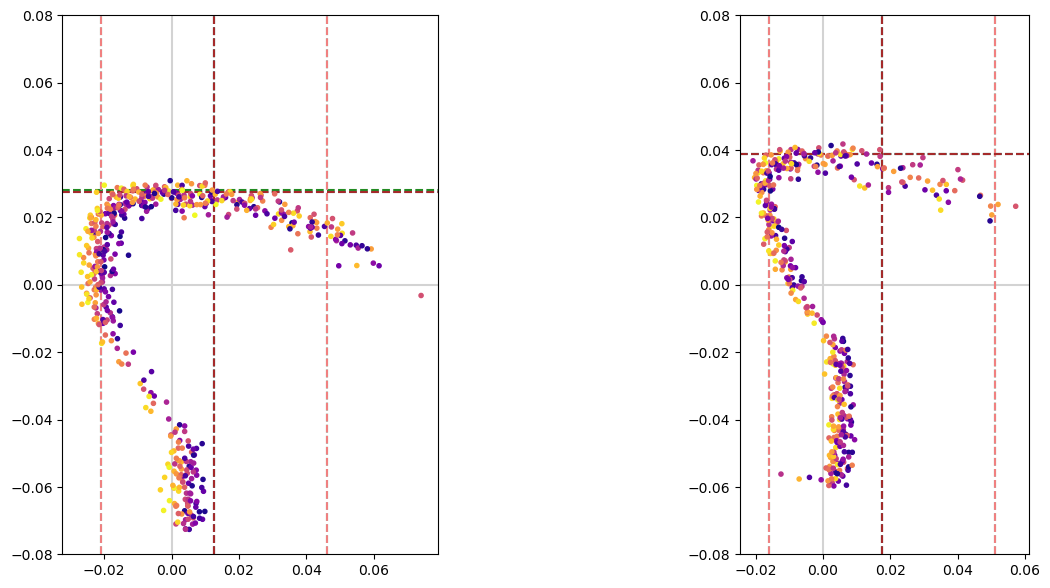

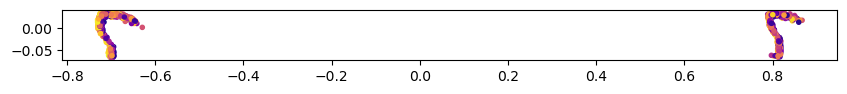

In [179]:
cluster, clustercenter, cluster_other, clustercenter_other, eigenvects = next(pair_gen)

percentile = 95

upperpercentile=90
lowerpercentile = 70

transformmatrix = get_transformmatrix(cluster, cluster_other, clustercenter, clustercenter_other, eigenvects)
#print("Transformmatrix")
#print(transformmatrix)

if transformmatrix[2,2] < 0: # z of the third eigenvector
    print("Inverted eigenvectors")
    transformmatrix *= -1
    
representive_a = representive_point(cluster, transformmatrix, percentile=percentile, lowerpercentile=lowerpercentile, railhead_width=0.067)
representive_b = representive_point(cluster_other, transformmatrix, percentile=percentile, lowerpercentile=lowerpercentile, railhead_width=0.067)

representative_aa = representive_point_1(cluster, transformmatrix, percentile=upperpercentile, lowerpercentile=lowerpercentile, railhead_width=0.067)
representative_bb = representive_point_1(cluster_other, transformmatrix, percentile=upperpercentile, lowerpercentile=lowerpercentile, railhead_width=0.067)


representative_aaa, side_a  = representive_point_3(cluster, transformmatrix, upperpercentile=upperpercentile, lowerpercentile=lowerpercentile, railhead_width=0.067)
representative_bbb, side_b = representive_point_3(cluster_other, transformmatrix, upperpercentile=upperpercentile, lowerpercentile=lowerpercentile, railhead_width=0.067)

print("Sides", side_a, side_b)

# Check if both are classified as the same side
# but a zero and non zero value is not a problem
if side_a * side_b < 0:
    print("Different sides")
    # Update the cluster with lower confidence of the side estimation
    if np.abs(side_a) < np.abs(side_b):
        representative_aaa, side_a  = representive_point_3(cluster, transformmatrix, upperpercentile=upperpercentile, lowerpercentile=lowerpercentile, railhead_width=0.067, side=side_b)
    else:
        representative_bbb, side_b = representive_point_3(cluster_other, transformmatrix, upperpercentile=upperpercentile, lowerpercentile=lowerpercentile, railhead_width=0.067, side=side_a)


    #representative_aaa, representative_bbb = representative_bbb, representative_aaa

central = get_central_point(representive_a, representive_b)
# print("Central Point", central)
# print("Representive Points:", representive_a, representive_b)

#o3d.visualization.draw_geometries([pcd_all, pcd_clusters, mesh_frame, pcd_clustercenters, pcd_representive])
print("Points per Cluster", len(cluster), len(cluster_other))
fig, ax, transformed, transformed_other = plot_cluster_pair_compare(cluster, cluster_other, transformmatrix, representive_a, representive_b, representative_aa, representative_bb, representative_aaa, representative_bbb, railhead_width = 0.067)

pair = np.vstack((cluster, cluster_other))
plot_cluster(pair, transformmatrix);
# Grün: Version 0; Blau: Version 1; Braun: Version 2

In [180]:
# fig.savefig("BackeZunge.png", dpi=300)

In [181]:
np.corrcoef(transformed[transformed[:,2]>0][:,0], transformed[transformed[:,2]>0][:,1])[0,1], np.corrcoef(transformed[transformed[:,2]<0][:,0], transformed[transformed[:,2]<0][:,1])[0,1]

(np.float64(-0.08387397586231739), np.float64(-0.18434400491082983))

In [182]:
np.corrcoef(transformed_other[transformed_other[:,2]>0][:,0], transformed_other[transformed_other[:,2]>0][:,1])[0,1], np.corrcoef(transformed_other[transformed_other[:,2]<0][:,0], transformed_other[transformed_other[:,2]<0][:,1])[0,1]

(np.float64(-0.0251827366463675), np.float64(-0.295167670157276))

In [183]:
pcd_clusters = o3d.geometry.PointCloud()
pcd_clusters.points = o3d.utility.Vector3dVector(pair)
pcd_clusters.paint_uniform_color([0, 0, 1])

pcd_clustercenters = o3d.geometry.PointCloud()
pcd_clustercenters.points = o3d.utility.Vector3dVector([clustercenter, clustercenter_other])
pcd_clustercenters.paint_uniform_color([0, 1, 0])

pcd_all = o3d.geometry.PointCloud()
pcd_all.points = o3d.utility.Vector3dVector(xyz)
pcd_all.paint_uniform_color([0.7, 0.7, 0.7])

pcd_representive = o3d.geometry.PointCloud()
pcd_representive.points = o3d.utility.Vector3dVector([representive_a, representive_b, central])
pcd_representive.paint_uniform_color([1, 0, 0])

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])

o3d.visualization.draw_geometries([pcd_all, pcd_clusters, mesh_frame, pcd_clustercenters, pcd_representive])

# Experimentieren

In [184]:
nrpoints = 1803127 
seconds = 3.7 + 1.5 + 1.5

seconds * 1000000 / nrpoints 

3.7157671090278166

In [185]:
nrpoints = 6000
seconds = 10/100 + 4/100

seconds * 1000000 / nrpoints 

23.333333333333332

In [186]:
# Clusterbeispiel speichern

prefix = "Auch komisch verschiedene Haken und Luecke"

pair = np.vstack((cluster, cluster_other))

save_clusters(cluster, cluster_other, pair, prefix)

FileExistsError: File already exists